In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from albumentations import RandomRotate90, VerticalFlip, HorizontalFlip, Compose, Normalize
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchmetrics import ConfusionMatrix
from tqdm import tqdm
from model_utils import build_model
from traineval import test_model, train_model_epoch, count_model_parameters

torch.__version__

c:\Users\enoch\.conda\envs\deeplearn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W1024 21:27:30.906000 14260 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


'2.8.0+cu129'

In [2]:
import torch

if torch.cuda.is_available():
    print(torch.cuda.memory_summary(device=None, abbreviated=False))
else:
    print("CUDA is not available. Cannot check GPU memory.")

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [3]:
DATASET_PATH = "../dataset"
LABELS = ["Haze", "Normal", "Smoke"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE

device(type='cuda')

In [4]:
def show_transformed_image(img):
    # undo the normalization for display
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Image shape: torch.Size([3, 256, 256])
Pixel range: [-2.1179039478302-2.6399998664855957]


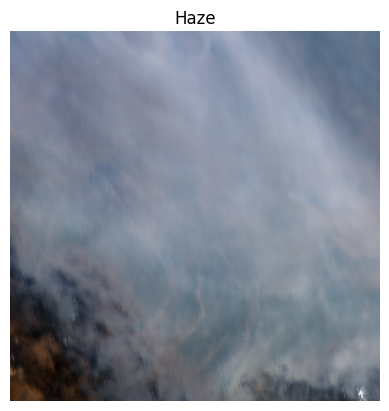

In [5]:
train_transform = Compose([
    RandomRotate90(),
    HorizontalFlip(),
    VerticalFlip(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

test_transform = Compose([
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_dset = ImageFolder("../USTCSmoke", transform=lambda x: train_transform(image=np.array(x))['image'])
test_dset = ImageFolder(os.path.join(DATASET_PATH, "test"), transform=lambda x: test_transform(image=np.array(x))['image'])

image, label_index = train_dset[0]
test_image, test_label_index = test_dset[0]
print("Image shape:", image.shape)
print(f"Pixel range: [{image.min()}-{image.max()}]")

# (H, W, C) for matplotlib
plt.title(LABELS[label_index]) #train_dset.class_to_idx -> {'haze': 0, 'normal': 1, 'smoke': 2}
show_transformed_image(image)

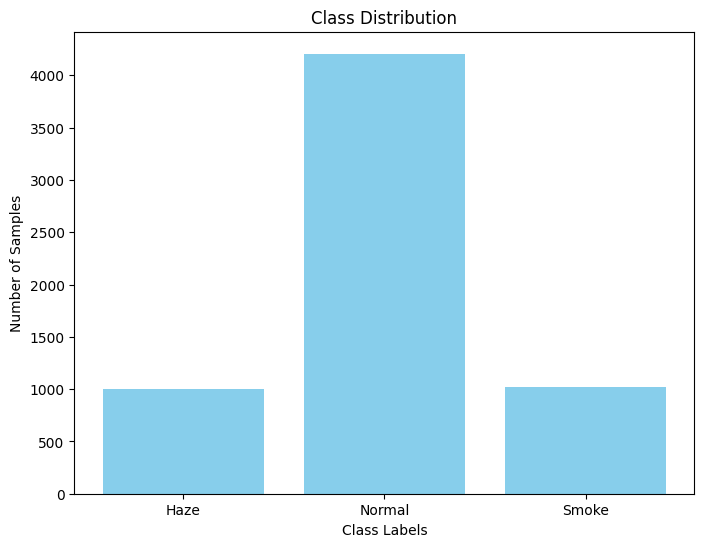

In [6]:
def plot_class_distribution(dataset, labels):
    class_counts = [0] * len(labels)
    for _, label in dataset:
        class_counts[label] += 1

    plt.figure(figsize=(8, 6))
    plt.bar(labels, class_counts, color='skyblue')
    plt.xlabel("Class Labels")
    plt.ylabel("Number of Samples")
    plt.title("Class Distribution")
    plt.show()

# Example usage:
plot_class_distribution(train_dset, LABELS)

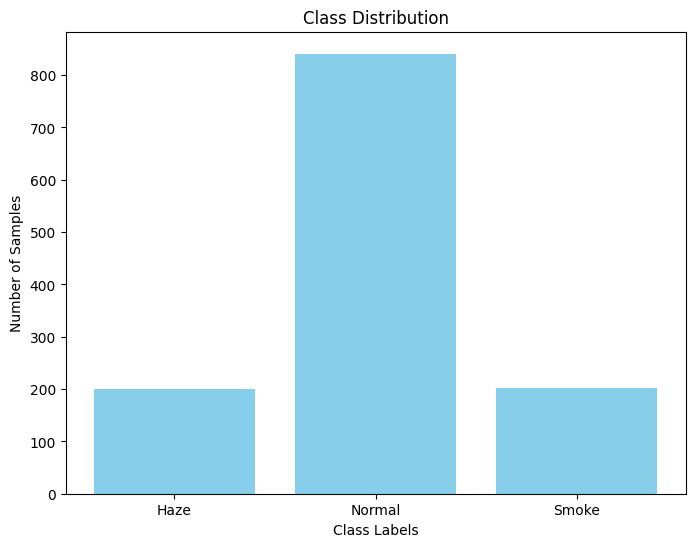

In [7]:
plot_class_distribution(test_dset, LABELS)

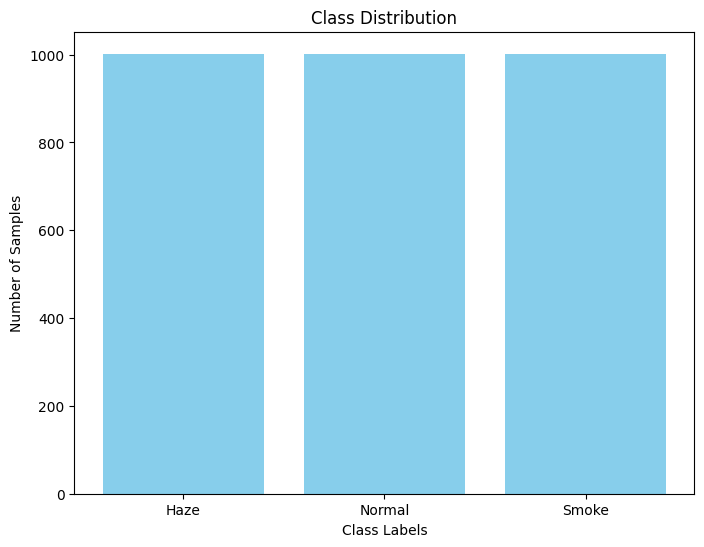

In [8]:
# undersampling of dataset to balance classes
# randomly not by truncating
from collections import defaultdict
def undersample_dataset(dataset):
    class_samples = defaultdict(list)
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        class_samples[label].append(idx)
    
    # Find minimum class size
    min_size = min(len(samples) for samples in class_samples.values())
    
    # Randomly sample indices from each class
    balanced_indices = []
    for label_indices in class_samples.values():
        selected = np.random.choice(label_indices, size=min_size, replace=False)
        balanced_indices.extend(selected)
    
    balanced_dataset = torch.utils.data.Subset(dataset, balanced_indices)
    return balanced_dataset

balanced_train_dset = undersample_dataset(train_dset)
plot_class_distribution(balanced_train_dset, LABELS)

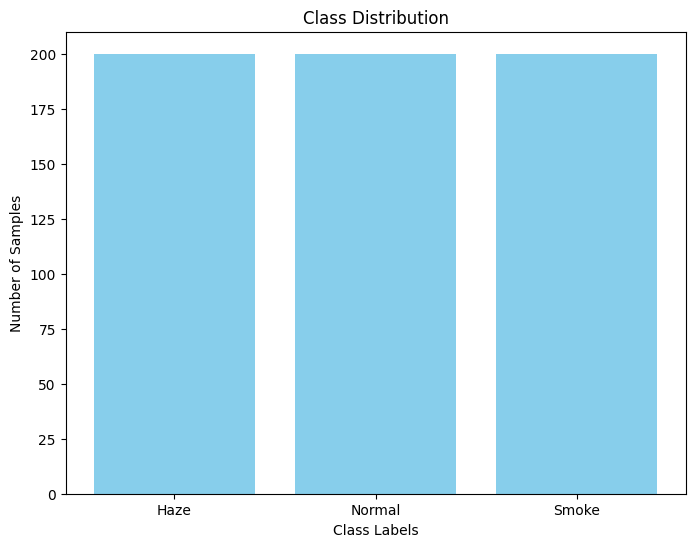

In [9]:
balanced_test_dset = undersample_dataset(test_dset)
plot_class_distribution(balanced_test_dset, LABELS)

In [10]:
from basic_cnn import BasicCNN

cnn = BasicCNN()
x = torch.randn(1, 3, 256, 256)
print(cnn(x).shape)

torch.Size([1, 3])


In [11]:
# plain backbones
CNNunmasked = build_model("basiccnn", use_heads=False)
VGG16unmasked = build_model("vgg16", use_heads=False)
ResNet50unmasked = build_model("resnet50", use_heads=False)

# augmented versions
CNNmasked = build_model("basiccnn", use_heads=True)
VGG16masked = build_model("vgg16", use_heads=True)
ResNet50masked = build_model("resnet50", use_heads=True)

# quick test
for name, model in [("basiccnn+heads", CNNmasked), ("vgg16+heads", VGG16masked), ("resnet50+heads", ResNet50masked)]:
    x = torch.randn(1,3,256,256)
    y = model(x)
    print(f"{name:15s} ->", tuple(y.shape))

for name, model in [("basiccnn", CNNunmasked), ("vgg16", VGG16unmasked), ("resnet50", ResNet50unmasked)]:
    x = torch.randn(1,3,256,256)
    y = model(x)
    print(f"{name:15s} ->", tuple(y.shape))


basiccnn+heads  -> (1, 3)
vgg16+heads     -> (1, 3)
resnet50+heads  -> (1, 3)
basiccnn        -> (1, 3)
vgg16           -> (1, 3)
resnet50        -> (1, 3)


In [12]:
train_loader = DataLoader(dataset=balanced_train_dset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dset, batch_size=32, shuffle=False)

data_batch = next(iter(train_loader))
imgs, labels = data_batch
imgs.shape, labels.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [13]:
LEARNING_RATE = 3e-4
NUM_EPOCHS = 100
model = build_model("basiccnn", use_heads=True, freeze_features=False)
model.to(DEVICE)
# model.load_weights("saves/vgg16-noheads.pt")
# model.load_state_dict(torch.load("saves/basic_cnn_model_undersampled_aug.pt", map_location=DEVICE))
writer = SummaryWriter()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params=model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

In [14]:
torch.cuda.empty_cache()
for epoch in range(NUM_EPOCHS):
    train_model_epoch(train_loader, test_loader, model, criterion, optimizer, writer, DEVICE=DEVICE, epoch=epoch)

100%|██████████| 39/39 [00:03<00:00, 10.85it/s]


In [19]:
model = build_model("resnet50", use_heads=True, freeze_features=False)
model.to(DEVICE)
model.load_state_dict(torch.load("saves/resnet50-withheads.pt", map_location=DEVICE))

<All keys matched successfully>

In [19]:
model = build_model("resnet50", use_heads=False, freeze_features=True)
model.to(DEVICE)
model.load_weights("saves/resnet50-noheadsMLP.pt")

In [ ]:
model.save_weights("saves/resnet50-noheadsMLP.pt")

In [20]:
loss, confmat, accuracy, precision, recall, f1_score = test_model(test_loader, model, DEVICE=DEVICE)
print("Confusion matrix:\n", confmat)
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1 Score: {f1_score*100:.2f}%")
#first row -> haze 
#second row -> normal
#third row -> smoke

# confusion matrix: format

# 1st row 1st column -> true haze predicted as haze
# 1st row 2nd column -> true haze predicted as normal
# 1st row 3rd column -> true haze predicted as smoke

100%|██████████| 39/39 [00:03<00:00, 11.51it/s]

Confusion matrix:
 [[197   0   3]
 [  9 821  11]
 [  1   0 202]]
Accuracy: 98.07%
Precision: 100.00%
Recall: 97.62%
F1 Score: 98.80%


In [16]:
torch.save(model.state_dict(), "saves/basiccnn-withheads.pt")

In [21]:
count_model_parameters("saves")

{'basiccnn-withheads.pt': 6682189,
 'basiccnn.pt': 6467203,
 'resnet50-withheads.pt': 24827321,
 'vgg16-withheads.pt': 136579332}

In [ ]:
# inf block

import sys, subprocess

# pick one
model_name = "resnet50"          # "basiccnn" | "vgg16" | "resnet50"
use_heads  = False               # True if you trained the +heads variant
weights    = "weights/resnet50_best.pth"
test_dir   = "evaluation/test_data"
out_csv    = "evaluation/output/sample_predictions.csv"

# optional: ground-truth CSV so 'actual_class' is filled with real labels
# leave as None if you don't have one for the test set
gt_csv = None  # e.g., "evaluation/test_labels.csv"

cmd = [
    sys.executable, "inference.py",
    "--model", model_name,
    "--weights", weights,
    "--test_dir", test_dir,
    "--out_csv", out_csv,
]
if use_heads:
    cmd.append("--use_heads")
if gt_csv:
    cmd += ["--gt_csv", gt_csv]

print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)
print("Done. CSV at:", out_csv)
